In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip list | grep torch

pytorch-ignite                     0.5.2
pytorch-lightning                  2.5.1.post0
torch                              2.6.0+cu124
torchao                            0.10.0
torchaudio                         2.6.0+cu124
torchdata                          0.11.0
torchinfo                          1.8.0
torchmetrics                       1.7.1
torchsummary                       1.5.1
torchtune                          0.6.1
torchvision                        0.21.0+cu124
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install ultralytics==8.3.160

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existin

In [2]:
from ultralytics import YOLO
model = YOLO("yolov8m-pose.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 50.8M/50.8M [00:00<00:00, 236MB/s]


In [3]:
import torch
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')  # GPU 사용 가능하면 GPU로
else:
    DEVICE = torch.device('cpu')   # 아니면 CPU로
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.6.0+cu124  Device: cuda


In [4]:
model = model.to(DEVICE)

In [5]:
import cv2

In [6]:
capture = cv2.VideoCapture('/kaggle/input/yolo8-squart/squart.mp4')

In [7]:
capture.get(cv2.CAP_PROP_FRAME_COUNT)

1501.0

In [8]:
from ultralytics.utils.plotting import Annotator

In [9]:
def draw_keypoints(result, frame):
    tmp_pose = {}
    global nkps
    annotator = Annotator(frame, line_width=1)
    for kps in result.keypoints:
        kps = kps.data.squeeze()
        annotator.kpts(kps)
       
        nkps = kps.cpu().numpy()
        # nkps[:,2] = 1
        # annotator.kpts(nkps)
        tmp_pose['왼쪽엉덩이']   = nkps[11]
        tmp_pose['오른쪽엉덩이'] = nkps[12]
        for idx, (x, y, score) in enumerate(nkps):
            if score > 0.5:
                cv2.circle(frame, (int(x), int(y)), 3, (0, 0, 255), cv2.FILLED)
                cv2.putText(frame, str(idx), (int(x), int(y)), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 1)
    pose.append([tmp_pose])
    return frame

In [10]:
def predict(frame, iou=0.7, conf=0.25):
    results = model(source=frame,
            device='cpu',
            iou=iou ,
            conf=conf ,
            verbose=False,
            )
    return results[0]


In [11]:
def draw_boxes(result, frame):
    for boxes in result.boxes:
        x1, y1, x2, y2, score, classes = boxes.data.squeeze().cpu().numpy()
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 1)
    return frame


In [12]:
capture = cv2.VideoCapture("/kaggle/input/yolo8-squart/squart.mp4")
pose = []
while True:
    ret, frame = capture.read()
    # print(capture.get(cv2.CAP_PROP_POS_FRAMES))
    state_frame = capture.get(cv2.CAP_PROP_POS_FRAMES)
    if state_frame % 30 == 0:
        print("저장")
        result = predict(frame)
    # frame = draw_boxes(result, frame)
        frame = draw_keypoints(result, frame)
    # frame = cv2.flip(frame, 1)


    # cv2.putText(frame, text, position, font, scale, color, thickness)
    if not ret:
        print("영상 오류")
        capture.release()
        cv2.destroyAllWindows()
        break


저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
저장
영상 오류


In [14]:
left_ = []
for left in pose:
    try:
        left_.append(left[0]['왼쪽엉덩이'][1])
    except:
        break

In [16]:
rigth_ = []
for right in pose:
    try:
        rigth_.append(right[0]['오른쪽엉덩이'][1])
    except:
        break

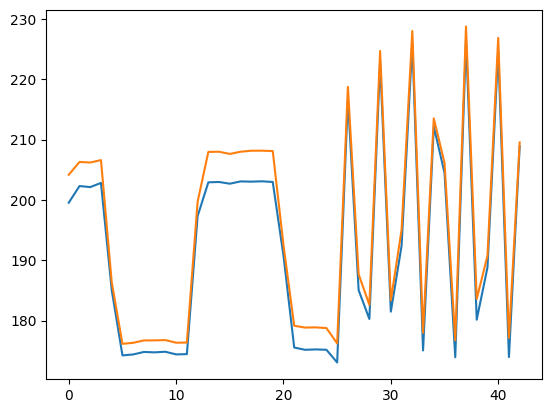

In [21]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(left_)), left_)
plt.plot(np.arange(len(left_)), rigth_)
plt.show()